In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py
%run decomposition.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Get Data

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

## Weather data

In [5]:
MetData_PLT = PLT.get_buoy('2022-01-01', '2023-07-01','PLT','MetData')
met_PLT = pd.DataFrame(MetData_PLT) 
met_PLT = met_PLT.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)

for k in met_PLT.keys():
    if k == 'DateTime':
        met_PLT[k] = pd.to_datetime(met_PLT[k], format = '%Y-%m-%D %H:%M:%S')

In [6]:
MetData_GB = PLT.get_buoy('2022-01-01', '2023-07-01','GB','MetData')
met_GB = pd.DataFrame(MetData_GB) 
met_GB = met_GB.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)

for k in met_GB.keys():
    if k == 'DateTime':
        met_GB[k] = pd.to_datetime(met_GB[k], format = '%Y-%m-%D %H:%M:%S')

## Combine with weather data

In [7]:
hydrocat620 = pd.merge_asof(hydrocat620, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)

In [8]:
QP = pd.merge_asof(QP, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
QP = QP.reset_index(drop=True)

In [9]:
hydrocat720 = pd.merge_asof(hydrocat720, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)

In [10]:
MV = pd.merge_asof(MV, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
MV = MV.reset_index(drop=True)

# Event 1: 12/20/22 to 12/28/22

In [30]:
hydro620 = hydrocat620.where(hydrocat620['DateTime'] >= datetime(2022,12,19)).where(hydrocat620['DateTime'] <= datetime(2022,12,28)).dropna()

hydro720 = hydrocat720.where(hydrocat720['DateTime'] >= datetime(2022,12,19)).where(hydrocat720['DateTime'] <= datetime(2022,12,28)).dropna()

In [31]:
[comp620, std620] = decomposition.decomposition(hydro620, 'D', location = 'PLT')
[comp720, std720] = decomposition.decomposition(hydro720, 'D', location = 'GB')

In [32]:
purple = '#6a4c93'
blue = '#1982c4'
green = '#8ac926'
yellow = '#ffca3a'
red = '#FF595E'
pink = '#ff6289'

In [33]:
COMP620 = comp620.copy()
COMP620 = COMP620.drop(columns = 'DateTime')
COMP620 = COMP620.reset_index()

COMP720 = comp720.copy()
COMP720 = COMP720.drop(columns = 'DateTime')
COMP720 = COMP720.reset_index()

# df = pd.merge_asof(COMPMV, COMPQP, on="DateTime",tolerance = pd.Timedelta("10m"))
df2 = pd.concat((COMP620,COMP720))
meancomp = df2.groupby(df2['DateTime']).mean()
meancomp

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,
2022-12-19,NaN,NaN,NaN,NaN,NaN,NaN,-1.580815e-05,NaN,NaN,NaN
2022-12-20,-0.000011,0.000039,-0.000462,-0.000019,0.000470,-0.000133,-1.277548e-05,-0.000152,7.477674e-06,-0.000129
2022-12-21,-0.000044,-0.000020,0.000302,0.000009,-0.000302,0.000059,-2.358729e-06,0.000068,2.860258e-07,0.000002
2022-12-22,-0.000054,-0.000026,0.000368,-0.000013,-0.000369,-0.000090,-2.362672e-07,-0.000103,-1.156215e-06,-0.000184
2022-12-23,0.000137,-0.000035,0.000466,-0.000020,-0.000469,-0.000143,-1.423294e-05,-0.000164,-3.620577e-06,-0.000080
2022-12-24,-0.000304,0.000041,-0.000596,0.000045,0.000598,0.000307,5.595219e-06,0.000352,1.391354e-06,0.000097
2022-12-25,-0.000300,0.000004,-0.000053,0.000050,0.000053,0.000344,6.371548e-07,0.000394,1.022724e-07,0.000098
2022-12-26,-0.000172,-0.000032,0.000514,0.000009,-0.000512,0.000065,2.161617e-06,0.000074,2.302324e-06,-0.000125
2022-12-27,-0.000193,-0.000140,0.002017,0.000169,-0.002020,0.001159,-7.679399e-06,0.001329,-3.495227e-06,0.000984


In [34]:
STD620 = std620.copy()
STD620 = STD620.drop(columns = 'DateTime')
STD620 = STD620.reset_index()

STD720 = std720.copy()
STD720 = STD720.drop(columns = 'DateTime')
STD720 = STD720.reset_index()

for i in STD620.index:
    for key in STD620.keys():
        if key != 'DateTime':
            STD620[key][i] = STD620[key][i]**2
for i in STD720.index:
    for key in STD720.keys():
        if key != 'DateTime':
            STD720[key][i] = STD720[key][i]**2
            
df2 = pd.concat((STD620,STD720))
meanstd = df2.groupby(df2['DateTime']).sum()

for i in meanstd.index:
    for key in meanstd.keys():
        if key != 'DateTime':
            meanstd[key][i] = np.sqrt(meanstd[key][i])
meanstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2022-12-19,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000
2022-12-20,0.000008,3.234977e-06,0.000038,0.000003,0.000039,0.000021,0.000006,0.000021,0.000054,0.000059
2022-12-21,0.000015,1.112852e-05,0.000156,0.000003,0.000157,0.000024,0.000002,0.000024,0.000222,0.000224
2022-12-22,0.000014,1.059726e-05,0.000149,0.000002,0.000149,0.000011,0.000003,0.000011,0.000211,0.000212
2022-12-23,0.000027,9.021430e-06,0.000126,0.000005,0.000127,0.000033,0.000025,0.000033,0.000179,0.000186
2022-12-24,0.000060,1.074127e-05,0.000157,0.000013,0.000157,0.000088,0.000010,0.000089,0.000222,0.000247
2022-12-25,0.000064,8.408551e-07,0.000012,0.000009,0.000012,0.000060,0.000007,0.000061,0.000017,0.000090
2022-12-26,0.000078,3.295333e-05,0.000478,0.000003,0.000479,0.000023,0.000004,0.000023,0.000676,0.000682
2022-12-27,0.000083,5.635568e-05,0.000816,0.000077,0.000817,0.000525,0.000003,0.000530,0.001155,0.001275


In [35]:
meancomp['DIC air sea flux'].iloc[0] = np.nan
meanstd['DIC ASF'].iloc[0] = 0
meanstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2022-12-19,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-20,0.000008,3.234977e-06,0.000038,0.000003,0.000039,0.000021,0.000006,0.000021,0.000054,0.000059
2022-12-21,0.000015,1.112852e-05,0.000156,0.000003,0.000157,0.000024,0.000002,0.000024,0.000222,0.000224
2022-12-22,0.000014,1.059726e-05,0.000149,0.000002,0.000149,0.000011,0.000003,0.000011,0.000211,0.000212
2022-12-23,0.000027,9.021430e-06,0.000126,0.000005,0.000127,0.000033,0.000025,0.000033,0.000179,0.000186
2022-12-24,0.000060,1.074127e-05,0.000157,0.000013,0.000157,0.000088,0.000010,0.000089,0.000222,0.000247
2022-12-25,0.000064,8.408551e-07,0.000012,0.000009,0.000012,0.000060,0.000007,0.000061,0.000017,0.000090
2022-12-26,0.000078,3.295333e-05,0.000478,0.000003,0.000479,0.000023,0.000004,0.000023,0.000676,0.000682
2022-12-27,0.000083,5.635568e-05,0.000816,0.000077,0.000817,0.000525,0.000003,0.000530,0.001155,0.001275


Text(1, -0.0015, 'BASIC')

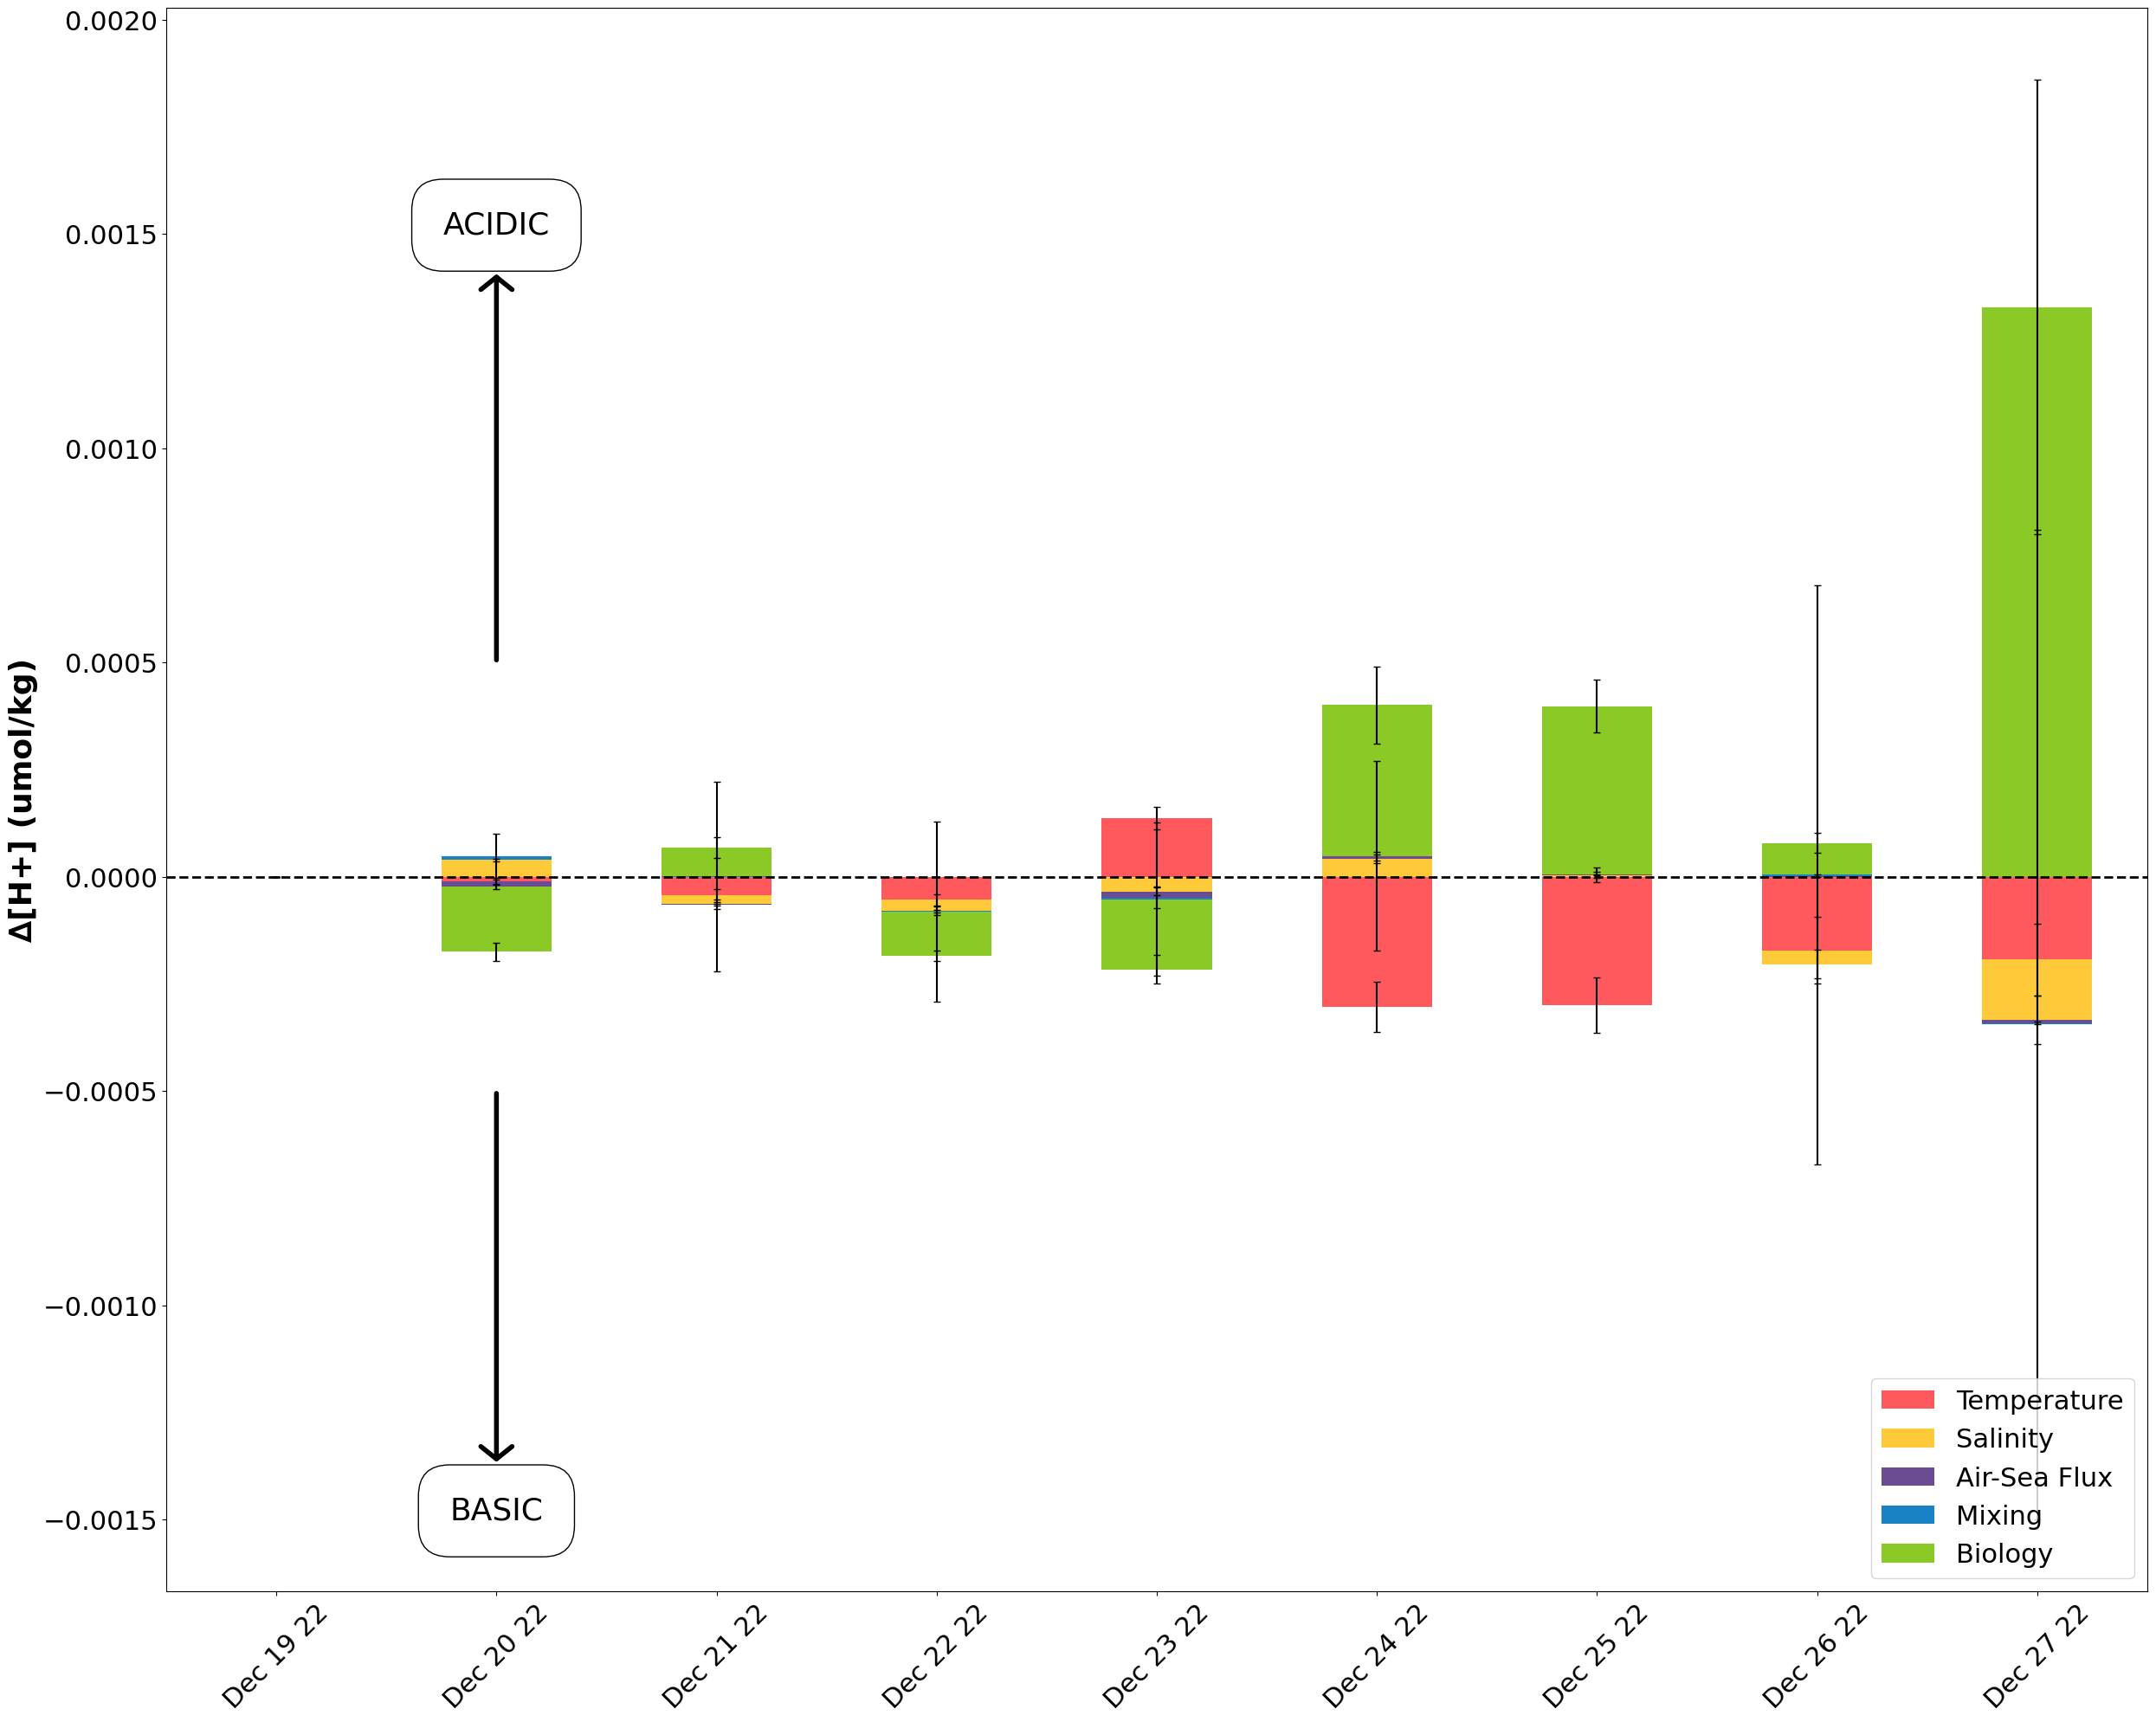

In [36]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(1, 1)

df = meancomp
dt = meanstd
title = 'Mean of All Sensors'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'Air-Sea Flux': df['DIC air sea flux'],
                     'Mixing': df['Total mixing'],
                     'Biology': df['Total bio']})
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'Air-Sea Flux': dt['DIC ASF'],
                     'Mixing': dt['Total mixing'],
                     'Biology': dt['Total bio']})

# fig, ax = plt.subplots(figsize = [12,8])
ax = fig.add_subplot(gs[0, 0])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%b %d %y'), fontsize = 22);
ax.tick_params('x',labelsize = 22, labelrotation = 45)
ax.tick_params('y',labelsize = 22)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 26, fontweight = 'bold')
ax.set_xlabel('', fontsize = 26)

ax.legend(loc = 'lower right', fontsize = 22)
# ax.set_title(title, fontsize = 18)

plt.annotate('ACIDIC',
             xy=(1,0.0005),
             xytext=(1, 0.0015), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.annotate('BASIC',
             xy=(1,-0.0005),
             xytext=(1, -0.0015), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))






# Event 2: 2/4/23 to 2/14/23

In [37]:
hydro620 = hydrocat620.where(hydrocat620['DateTime'] >= datetime(2023,2,4)).where(hydrocat620['DateTime'] <= datetime(2023,2,14)).dropna()

hydro720 = hydrocat720.where(hydrocat720['DateTime'] >= datetime(2023,2,4)).where(hydrocat720['DateTime'] <= datetime(2023,2,14)).dropna()

In [38]:
[comp620, std620] = decomposition.decomposition(hydro620, 'D', location = 'PLT')
[comp720, std720] = decomposition.decomposition(hydro720, 'D', location = 'GB')

In [39]:
COMP620 = comp620.copy()
COMP620 = COMP620.drop(columns = 'DateTime')
COMP620 = COMP620.reset_index()

COMP720 = comp720.copy()
COMP720 = COMP720.drop(columns = 'DateTime')
COMP720 = COMP720.reset_index()

# df = pd.merge_asof(COMPMV, COMPQP, on="DateTime",tolerance = pd.Timedelta("10m"))
df2 = pd.concat((COMP620,COMP720))
meancomp = df2.groupby(df2['DateTime']).mean()
meancomp

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,
2023-02-04,NaN,NaN,NaN,NaN,NaN,NaN,0.000061,NaN,NaN,NaN
2023-02-05,-0.000062,-0.000029,0.000322,-0.000037,-0.000328,-0.000257,0.000050,-0.000294,-0.000006,-0.000340
2023-02-06,0.000033,-0.000056,0.000621,-0.000031,-0.000633,-0.000215,0.000037,-0.000246,-0.000012,-0.000244
2023-02-07,-0.000063,-0.000218,0.002442,0.000008,-0.002488,0.000050,0.000043,0.000057,-0.000045,-0.000225
2023-02-08,-0.000032,-0.000114,0.000993,-0.000102,-0.001032,-0.000726,0.000040,-0.000829,-0.000039,-0.000973
2023-02-09,0.000059,0.000040,-0.000376,0.000074,0.000388,0.000520,0.000017,0.000593,0.000012,0.000721
2023-02-10,0.000150,0.000093,-0.000922,0.000030,0.000948,0.000209,0.000077,0.000239,0.000027,0.000585
2023-02-11,0.000072,0.000027,-0.000277,0.000017,0.000285,0.000119,0.000045,0.000136,0.000008,0.000289
2023-02-12,0.000036,-0.000014,0.000134,-0.000027,-0.000138,-0.000188,0.000020,-0.000215,-0.000004,-0.000177


In [40]:
STD620 = std620.copy()
STD620 = STD620.drop(columns = 'DateTime')
STD620 = STD620.reset_index()

STD720 = std720.copy()
STD720 = STD720.drop(columns = 'DateTime')
STD720 = STD720.reset_index()

for i in STD620.index:
    for key in STD620.keys():
        if key != 'DateTime':
            STD620[key][i] = STD620[key][i]**2
for i in STD720.index:
    for key in STD720.keys():
        if key != 'DateTime':
            STD720[key][i] = STD720[key][i]**2
            
df2 = pd.concat((STD620,STD720))
meanstd = df2.groupby(df2['DateTime']).sum()

for i in meanstd.index:
    for key in meanstd.keys():
        if key != 'DateTime':
            meanstd[key][i] = np.sqrt(meanstd[key][i])
meanstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2023-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000
2023-02-05,0.000026,0.000008,0.000089,0.000012,0.000091,0.000086,0.000013,0.000086,0.000127,0.000157
2023-02-06,0.000010,0.000018,0.000201,0.000006,0.000205,0.000045,0.000007,0.000045,0.000287,0.000291
2023-02-07,0.000036,0.000069,0.000769,0.000026,0.000784,0.000181,0.000015,0.000183,0.001099,0.001117
2023-02-08,0.000009,0.000030,0.000262,0.000027,0.000274,0.000193,0.000011,0.000195,0.000379,0.000427
2023-02-09,0.000014,0.000009,0.000083,0.000016,0.000086,0.000116,0.000004,0.000117,0.000120,0.000168
2023-02-10,0.000016,0.000007,0.000073,0.000002,0.000075,0.000016,0.000006,0.000017,0.000104,0.000107
2023-02-11,0.000006,0.000002,0.000022,0.000001,0.000023,0.000010,0.000004,0.000010,0.000032,0.000034
2023-02-12,0.000003,0.000001,0.000010,0.000002,0.000010,0.000014,0.000002,0.000014,0.000014,0.000020


In [43]:
meancomp['DIC air sea flux'].iloc[0] = np.nan
meanstd['DIC ASF'].iloc[0] = 0
meanstd

,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC bio,DIC ASF,Total bio,Total mixing,Total error
DateTime,,,,,,,,,,
2023-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-02-05,0.000026,0.000008,0.000089,0.000012,0.000091,0.000086,0.000013,0.000086,0.000127,0.000157
2023-02-06,0.000010,0.000018,0.000201,0.000006,0.000205,0.000045,0.000007,0.000045,0.000287,0.000291
2023-02-07,0.000036,0.000069,0.000769,0.000026,0.000784,0.000181,0.000015,0.000183,0.001099,0.001117
2023-02-08,0.000009,0.000030,0.000262,0.000027,0.000274,0.000193,0.000011,0.000195,0.000379,0.000427
2023-02-09,0.000014,0.000009,0.000083,0.000016,0.000086,0.000116,0.000004,0.000117,0.000120,0.000168
2023-02-10,0.000016,0.000007,0.000073,0.000002,0.000075,0.000016,0.000006,0.000017,0.000104,0.000107
2023-02-11,0.000006,0.000002,0.000022,0.000001,0.000023,0.000010,0.000004,0.000010,0.000032,0.000034
2023-02-12,0.000003,0.000001,0.000010,0.000002,0.000010,0.000014,0.000002,0.000014,0.000014,0.000020


Text(1, -0.0015, 'BASIC')

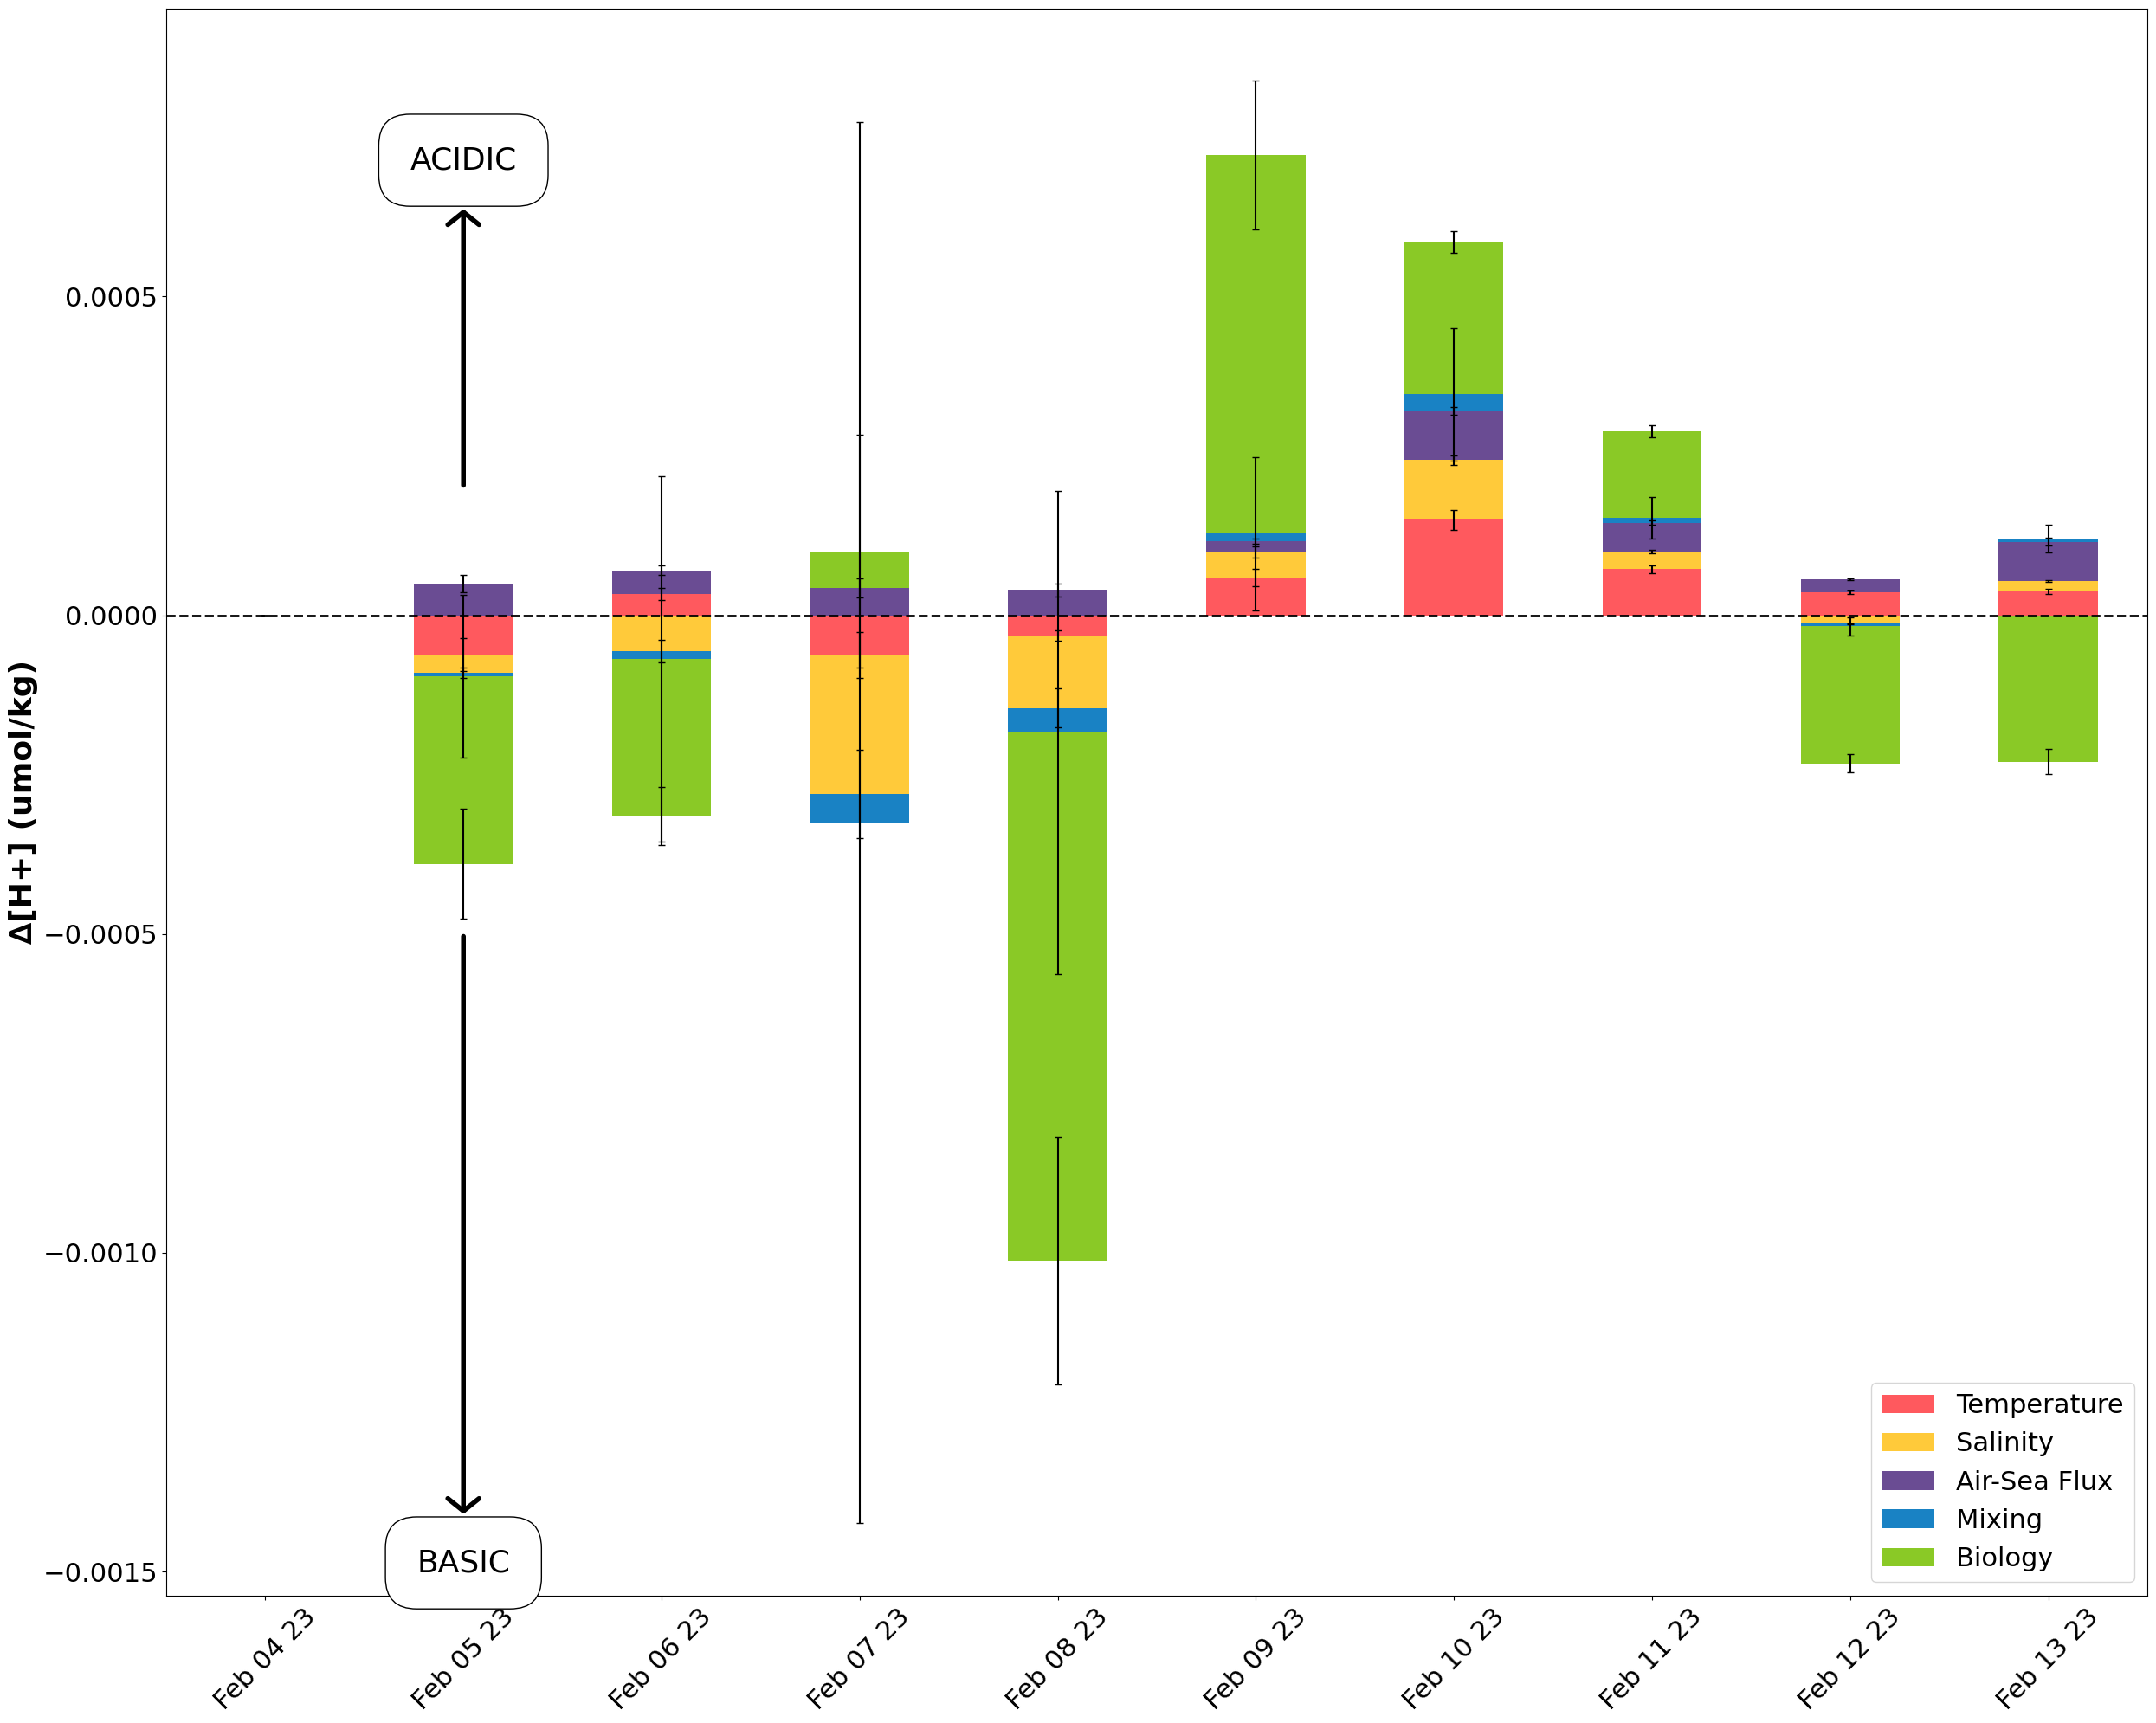

In [46]:
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
fig = plt.figure(figsize = [25,20],tight_layout=True)
gs = gridspec.GridSpec(1, 1)

df = meancomp
dt = meanstd
title = 'Mean of All Sensors'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'Air-Sea Flux': df['DIC air sea flux'],
                     'Mixing': df['Total mixing'],
                     'Biology': df['Total bio']})
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'Air-Sea Flux': dt['DIC ASF'],
                     'Mixing': dt['Total mixing'],
                     'Biology': dt['Total bio']})

# fig, ax = plt.subplots(figsize = [12,8])
ax = fig.add_subplot(gs[0, 0])
# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
# ax.bar(df['DateTime'], df['Total'], color = 'cyan', width = 15,label = 'Total', zorder = 3)
df_.plot(kind='bar',  yerr = err_, color = [red,yellow,purple,blue,green], capsize = 3,
         stacked=True, ax = ax)
ax.set_xticklabels(df.index.strftime('%b %d %y'), fontsize = 22);
ax.tick_params('x',labelsize = 22, labelrotation = 45)
ax.tick_params('y',labelsize = 22)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 26, fontweight = 'bold')
ax.set_xlabel('', fontsize = 26)

ax.legend(loc = 'lower right', fontsize = 22)
# ax.set_title(title, fontsize = 18)

plt.annotate('ACIDIC',
             xy=(1,0.0002),
             xytext=(1, 0.0007), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.annotate('BASIC',
             xy=(1,-0.0005),
             xytext=(1, -0.0015), horizontalalignment="center",
             arrowprops=dict(arrowstyle='<- , head_width = 0.5',lw=4), fontsize = 26,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))




